<a href="https://colab.research.google.com/github/supriyamk2/Covid_QnA_NLPbert/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import seaborn as sns
sns.set_theme(style='darkgrid')
import pandas as pd

In [4]:
df_final = pd.read_csv('/content/drive/MyDrive/datasets/FINAL_CORD_DATA.csv')

In [6]:
df_final.head()

,sha,title,abstract,publish_time,authors,url,body_text
0,feedfe27a4eee49d8a1d09f50e8ecfe73057602a,Experiences and effects of telerehabilitation ...,BACKGROUND: The announcement of a national loc...,2021-06-30,"Ebrahim, Humairaa; Pillay-Jayaraman, Prithi; L...",https://www.ncbi.nlm.nih.gov/pubmed/34230898/;...,"As a result of the COVID-19 pandemic, many pat..."
1,c2ca01f12643a88e059e81619fb971fa61de3971,SCOAT-Net: A novel network for segmenting COVI...,Automatic segmentation of lung opacification f...,2021-06-10,"Zhao, Shixuan; Li, Zhidan; Chen, Yang; Zhao, W...",https://www.ncbi.nlm.nih.gov/pubmed/34127870/;...,"The coronavirus disease 2019 (COVID-19), which..."
2,d0d1e05bb14f068d8323807ba042860887b7aa00,A Comprehensive Review on Factors Influences B...,Exosomes are nanoscale-sized membrane vesicles...,2021-02-17,"Gurunathan, Sangiliyandi; Kang, Min-Hee; Kim, ...",https://doi.org/10.2147/ijn.s291956; https://w...,Extracellular vesicles (EVs) including exosome...
3,fb8c3a315b4a345dafc7e59be000e21bf965dea8,Opposition to cannabis legalization on public ...,NaN,2021-04-13,"Smyth, Bobby P; Christie, Grant IG",https://doi.org/10.1016/j.lanwpc.2021.100142; ...,Both authors contributed to the drafting of th...
4,ed4c180c272b047c6db958508fb9a8edd40cb1cb,An epigenetic signature to fight COVID-19,NaN,2021-05-13,"Herbein, Georges",https://www.ncbi.nlm.nih.gov/pubmed/33993054/;...,Research performed in our laboratories is supp...


In [7]:
df_final.shape

(24910, 7)

In [10]:
def inspect_data(data):
  return pd.DataFrame(
      {
          'Data Types':data.dtypes,
           'No of level':data.apply(lambda x: len(x.unique()),axis=0),
           'levels':data.apply(lambda x : x.unique(),axis=0),
           'qtd_null': data.apply(lambda x:x.isnull().sum(),axis=0),
           'pct_null': data.apply(lambda x:x.isnull().sum()* 100/len(x))
       
          

      }
      

    
  )

In [11]:
inspect_data(df_final)

,Data Types,No of level,levels,qtd_null,pct_null
sha,object,24910,"[feedfe27a4eee49d8a1d09f50e8ecfe73057602a, c2c...",0,0.000000
title,object,24859,[Experiences and effects of telerehabilitation...,0,0.000000
abstract,object,21913,[BACKGROUND: The announcement of a national lo...,2940,11.802489
publish_time,object,3302,"[2021-06-30, 2021-06-10, 2021-02-17, 2021-04-1...",0,0.000000
authors,object,24552,"[Ebrahim, Humairaa; Pillay-Jayaraman, Prithi; ...",227,0.911281
url,object,24910,[https://www.ncbi.nlm.nih.gov/pubmed/34230898/...,0,0.000000
body_text,object,24756,"[As a result of the COVID-19 pandemic, many pa...",0,0.000000


In [12]:
df_final['publish_time'] = pd.to_datetime(df_final['publish_time'])

In [13]:
df_final['publish_year'] = df_final['publish_time'].dt.year
df_final['publish_month'] = df_final['publish_time'].dt.month
df_final['publish_day'] = df_final['publish_time'].dt.day

In [14]:
df_final['publish_year'].nunique()

53

In [15]:
df_final['publish_month'].nunique()

12

In [16]:
df_final['publish_day'].nunique()

31

In [17]:
df_final['publish_year'].min()

1961

In [18]:
df_final['publish_year'].max()

2022

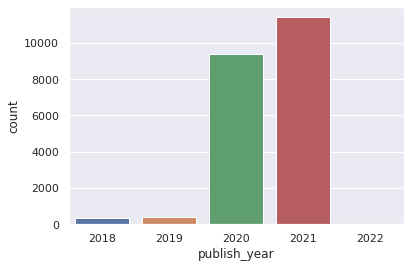

In [19]:
sns.countplot(
    
    x='publish_year',data=df_final[df_final['publish_year'].isin([2018,2019,2020,2021,2022])]
)

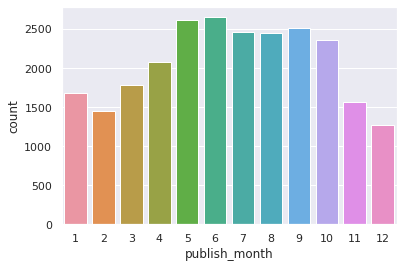

In [21]:
sns.countplot(x='publish_month',data =df_final)

WordClouds

In [22]:
from wordcloud import WordCloud, STOPWORDS

In [23]:
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
def plot_Word_cloud(wordcloud):
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis('off')

In [25]:
#clean up the abstract text to avoid noise
def clean_data(text):
  pattern = r'[^a-zA-z0-9\'\s]'
  txt = re.sub(pattern,'',text)
  txt = ''.join([c for c in txt if c not in string.punctuation])
  return txt

In [27]:
clean_abstract = df_final.loc[df_final.abstract.notnull(),'abstract'].apply(clean_data)

In [26]:
def concat_all_sentences(sents):
  all_tokens = ''
  for text in sents:
    tx = str(text).lower().strip()
    tx = " ".join(tx.split())
    all_tokens += tx + " "
  return all_tokens

In [28]:
abstract_tokens = concat_all_sentences(clean_abstract)


In [29]:
abstract_wordcloud = WordCloud(width=500,height = 500, random_state=10).generate(abstract_tokens)

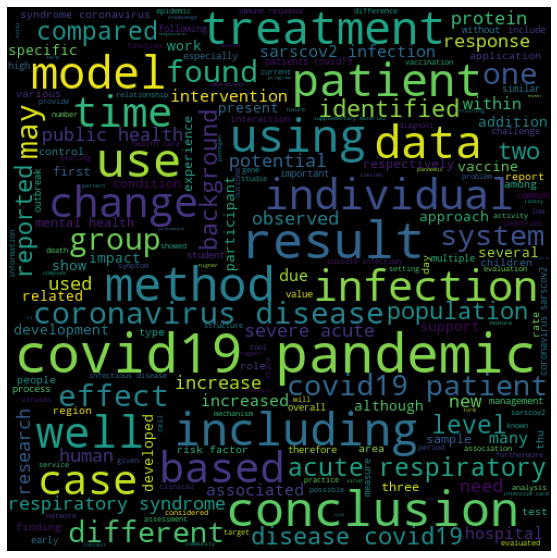

In [31]:
plot_Word_cloud(abstract_wordcloud)

# Topic Modelling

In [34]:
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [35]:
abstracts = clean_abstract.values.tolist()

In [39]:
def token_builder(sentences):
  for sent in sentences:
    sent = simple_preprocess(str(sent),deacc=True)
    yield(sent)

In [40]:
abstract_tokens = list(token_builder(abstracts))

In [41]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(abstract_tokens, min_count=3, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[abstract_tokens], threshold=50)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [42]:
import nltk


In [43]:
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [44]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [45]:
def process_docs(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization   
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out] 
    return texts_out


In [46]:
abstracts_data = process_docs(abstract_tokens)


In [47]:
id2word = corpora.Dictionary(abstracts_data)

In [48]:
print(id2word.token2id)

{'able': 0, 'access': 1, 'allow': 2, 'alternative': 3, 'ask': 4, 'attend': 5, 'cancellation': 6, 'clinical': 7, 'communication': 8, 'conclusion': 9, 'consider': 10, 'cost': 11, 'current': 12, 'deliver': 13, 'delivery': 14, 'discharge': 15, 'discussion': 16, 'electronic': 17, 'enable': 18, 'ensure': 19, 'experience': 20, 'face': 21, 'feasibility': 22, 'feasible': 23, 'format': 24, 'health': 25, 'identification': 26, 'impact': 27, 'implication': 28, 'include': 29, 'indicate': 30, 'manage': 31, 'method': 32, 'methodsdesign': 33, 'mix': 34, 'necessary': 35, 'necessitate': 36, 'nonattendance': 37, 'nontraditional': 38, 'offer': 39, 'often': 40, 'outcome': 41, 'outpatient': 42, 'pandemic': 43, 'participant': 44, 'patient': 45, 'physiotherapy': 46, 'prefer': 47, 'prioritisation': 48, 'prospective': 49, 'protect': 50, 'protocol': 51, 'provide': 52, 'provision': 53, 'reason': 54, 'receive': 55, 'recruit': 56, 'rehabilitation': 57, 'result': 58, 'risk': 59, 'service': 60, 'situation': 61, 'still

In [49]:
#Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in abstracts_data]

In [50]:
#build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [52]:
print(lda_model.print_topics())

[(0, '0.009*"study" + 0.007*"result" + 0.007*"covid" + 0.007*"pandemic" + 0.006*"model" + 0.006*"health" + 0.005*"method" + 0.005*"system" + 0.005*"datum" + 0.005*"care"'), (1, '0.029*"patient" + 0.013*"infection" + 0.010*"study" + 0.009*"covid" + 0.008*"disease" + 0.008*"virus" + 0.008*"result" + 0.007*"treatment" + 0.006*"cell" + 0.006*"include"')]


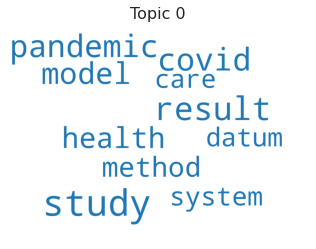

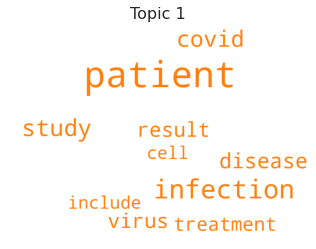

In [53]:
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

for i in range(0,2):
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    plt.show()

In [54]:
topics = lda_model.show_topics(formatted=False)

In [55]:
topics

[(0,
  [('study', 0.0094689075),
   ('result', 0.0074382913),
   ('covid', 0.0069663785),
   ('pandemic', 0.0068671308),
   ('model', 0.0063891606),
   ('health', 0.0058663734),
   ('method', 0.0053513553),
   ('system', 0.0047570798),
   ('datum', 0.0047140247),
   ('care', 0.0046671745)]),
 (1,
  [('patient', 0.029260691),
   ('infection', 0.013042723),
   ('study', 0.0101150265),
   ('covid', 0.009465374),
   ('disease', 0.008255344),
   ('virus', 0.007734277),
   ('result', 0.007606636),
   ('treatment', 0.0066818516),
   ('cell', 0.0056179003),
   ('include', 0.0056150584)])]